# Importing the Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import easyocr
import cv2
from matplotlib import pyplot as plt
import math
from torch import nn
import torch
import torchvision.models as models
import time
import copy

# Downloading the packages

In [2]:
!pip install torchsummary

In [3]:
from torchsummary import summary

# Defining Hyperparameters

In [4]:
class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    IMG_SIZE = (224, 224)
    IMG_DIR = "/kaggle/input/facebook-hateful-meme-dataset/data"
    TRAIN_LABELS = "/kaggle/input/facebook-hateful-meme-dataset/data/train.jsonl"
    VAL_LABELS = "/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl"
    BATCH_SIZE = 32 
    NUM_CLASSES = 2
    FREEZE_CNN = True

Mostly we will work on GPU so lets check our current device

In [5]:
config.DEVICE

'cuda'

# Image Preprocessing

## Custom Image Preprocessing Pipeline

In [6]:
import torchvision.transforms as T

class ImagePreprocessing:
    
    def __init__(self, img_size, ocr_pipeline):
        self.img_size = img_size
        self.ocr = ocr_pipeline
    
    def __call__(self, img):
#         print(img.numpy().shape)
#         prediction_groups = self.ocr.recognize([img])
        mask = np.zeros(img.shape[:2], dtype="uint8")
        result = self.ocr.readtext(img, paragraph = True)
        for (box, text) in result:
            (tl, tr, br, bl) = box
            x0, y0 = (int(tl[0]), int(tl[1]))
            x1, y1 = (int(br[0]), int(br[1])) 
            x2, y2 = (int(tr[0]), int(tr[1]))
            x3, y3 = (int(bl[0]), int(bl[1])) 

            x_mid0, y_mid0 = self.midpoint(x1, y1, x2, y2)
            x_mid1, y_mi1 = self.midpoint(x0, y0, x3, y3)

            thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

            cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
            thickness)
            img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = torch.tensor(img, dtype=torch.float64)
        img = torch.tensor(img)
        img = img.permute(2, 0, 1) / 255.0
        preprocess = T.Compose([
           T.Resize(self.img_size),
#            T.CenterCrop(224),
#            T.Normalize(
#                mean=[0.485, 0.456, 0.406],
#                std=[0.229, 0.224, 0.225]
#              )
        ])
        
        img = preprocess(img)
        return img
    
    
    def midpoint(self, x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

## Visualizing the After Preprocessing Effects

In [7]:
def displayImages(img_dir, img_ids, ocr_pipeline):
    
    plt.figure(figsize = (15,8))
    idx = 1
    for img_id in img_ids:
        
        img_path = os.path.join(img_dir, img_id)
        plt.subplot(len(img_ids), 2, idx)
        img = cv2.imread(img_path)
        img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img1)
        plt.title("Before Preprocessing")
        plt.axis(False)

        idx += 1
        plt.subplot(len(img_ids), 2, idx)
        preprocessor = ImagePreprocessing((img.shape[0], img.shape[1]), ocr_pipeline)
        processed_img = preprocessor(img).permute(1,2,0)
        plt.imshow(processed_img)
        plt.title("After Preprocessing")
        plt.axis(False)
        idx += 1
    plt.subplots_adjust(top=0.90, bottom = -0.5, left = 0.3)

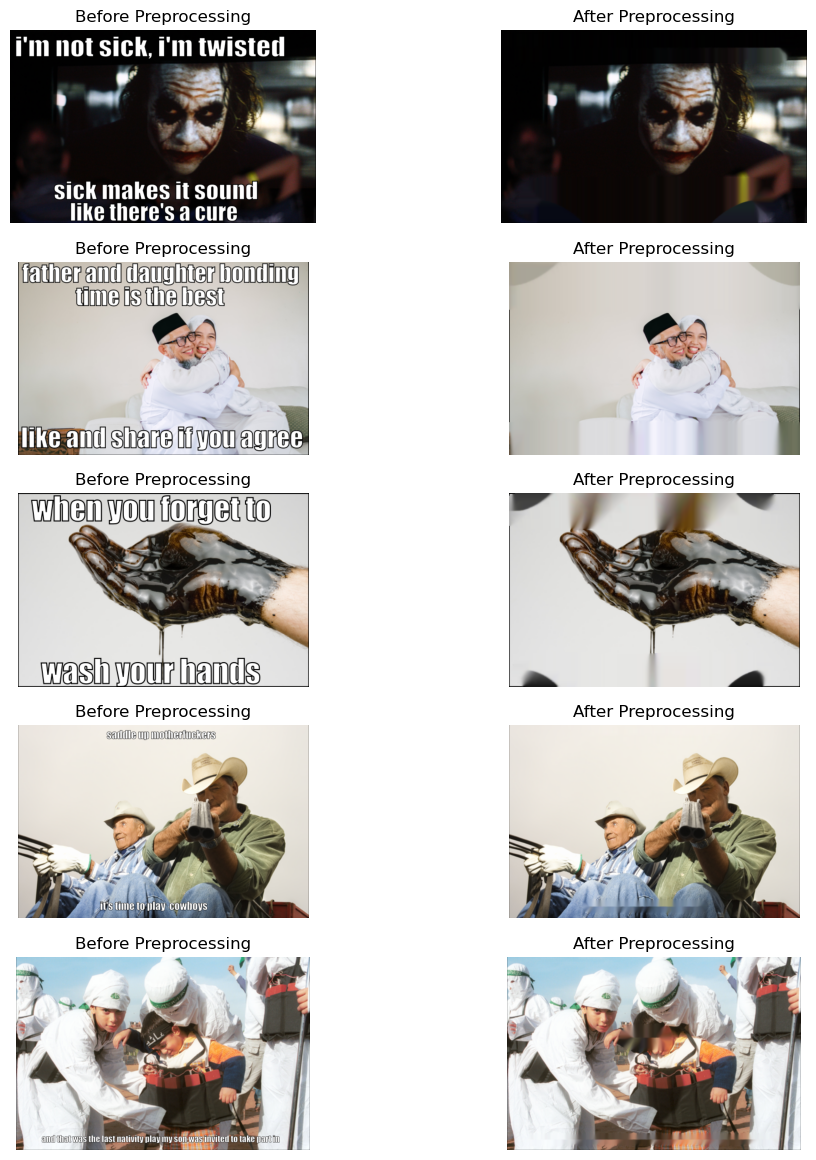

In [8]:
img_ids = ["01327.png", "01268.png", "01293.png", "01329.png", "01364.png"]
# img_ids = ["01243.png", "01268.png"]
img_dir = "/kaggle/input/facebook-hateful-meme-dataset/data/img"
reader = easyocr.Reader(['en']) 
displayImages(img_dir, img_ids, reader)

Well we can observe the Preprocessing effect on the images as it removed all kind of texts written on the images. After preprocessing lets make our data for pytroch Model.

# Custom Dataset of Pytorch Model

In [9]:
from torchvision.io import read_image
import torch

class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_dir, labels_file, transform = None):
        
        self.img_dir = img_dir
        self.labels = pd.read_json(labels_file, lines = True)
        self.transform = transform
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.labels.loc[idx, 'img'])
#         img = read_image(img_path)
#         print(img_path)
        img = cv2.imread(img_path)
        label = self.labels.loc[idx, 'label']
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [10]:
reader = easyocr.Reader(['en']) 

transformations = ImagePreprocessing(config.IMG_SIZE, reader)

train_dataset = CustomDataset(config.IMG_DIR, config.TRAIN_LABELS, transformations)
val_dataset = CustomDataset(config.IMG_DIR, config.VAL_LABELS, transformations)

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.BATCH_SIZE, shuffle = False)

Preprocessing phase is done and we have a dataloader ready for our pytorch model so lets load a pretrained pytorch model and fine tune it according to our task.

# Training a Model

## Defining The Model

In [12]:
class CustomVGG19(torch.nn.Module):
    
    def __init__(self, num_class, freeze_cnn):
        super().__init__()
        self.num_class = num_class
        self.freeze_cnn = freeze_cnn
        self.vgg19 = models.vgg19(pretrained = True)
        self.fine_tune = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=4096, out_features=1024, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=1024, out_features=512, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.2, inplace=False),
                                         nn.Linear(in_features=512, out_features=100, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Linear(in_features=100, out_features=self.num_class, bias=True))
        self.vgg19.classifier = self.fine_tune

        
    def forward(self, x):
        
        if self.freeze_cnn:
            self.vgg19.features.requires_grad_ = False

        return self.vgg19(x)

In [13]:
vgg19 = CustomVGG19(config.NUM_CLASSES, config.FREEZE_CNN).to(config.DEVICE)
print(vgg19.vgg19)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
summary(vgg19.vgg19, (3, *config.IMG_SIZE)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Definig the model hyperparameters

In [15]:
class modelConfig:
    LR = 0.001
    MOMENTUM = 0.9
    GAMMA = 0.1
    STEP_SIZE = 7
    BATCH_SIZE = 32
    EPOCHS = 2
    

## Defining the loss + optimizer + exponential scheduler for learning rate

In [16]:
from torch import optim

# Loss Function for the model
criterion = nn.CrossEntropyLoss().to(config.DEVICE)

In [17]:
# List of all non freezed parameters
non_frozen_parameters = [p for p in vgg19.parameters() if p.requires_grad]

In [18]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(non_frozen_parameters, lr = modelConfig.LR, momentum = modelConfig.MOMENTUM)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = modelConfig.STEP_SIZE, 
                                             gamma = modelConfig.GAMMA)

## Training Process

In [19]:
from tqdm import tqdm
def train_model(model, trainloader, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in tqdm(trainloader):
            inputs = inputs.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # To save GPU memory
            del inputs
        scheduler.step()
        dataset_sizes = len(trainloader)
        epoch_loss = running_loss / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes
        print('Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))
    
    return model, optimizer

In [20]:
vgg19_trained, optimizer_after_train = train_model(vgg19, train_loader, criterion, optimizer, 
                                                   exp_lr_scheduler, num_epochs = modelConfig.EPOCHS)

Epoch 0/1
----------


100%|██████████| 266/266 [1:37:35<00:00, 22.01s/it]


Loss: 21.0876 Acc: 20.4887
Epoch 1/1
----------


100%|██████████| 266/266 [1:37:22<00:00, 21.96s/it]

Loss: 20.7740 Acc: 20.4887


## Saving the Fine Tuned Model

In [21]:
model_state_dicts = {"model" : vgg19_trained.state_dict(), 
                     "optimizer" : optimizer_after_train.state_dict()}
torch.save(model_state_dicts, "vgg19-fine-tuned.pt")

# Image Embeddings

In [22]:
# # # Until the model get trains
# vgg19_trained = vgg19
# optimizer_after_train = optimizer

In [23]:
def makeEmbeddingModel(vgg19_trained, dim = 100):
    
    # Remove last 2 layers to get the 100 dim embedding
    model = copy.deepcopy(vgg19_trained)
    if dim == 100:
        for _ in range(2):
            temp = model.vgg19.classifier.pop(-1)
    
    elif dim == 512:
        for _ in range(5):
            temp = model.vgg19.classifier.pop(-1)
    else:
        print("You could only choose 100 or 512 dimenssional embeddings")
    
    return model
        

In [24]:
# Dim could only be 100 or 512
embedding_model = makeEmbeddingModel(vgg19_trained, 100)

In [25]:
embedding_model.vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Inference Dataset

In [26]:
from torchvision.io import read_image
import torch

class InferenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_dir, labels_file, transform = None):
        
        self.img_dir = img_dir
        self.labels = pd.read_json(labels_file, lines = True)
        self.transform = transform
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.labels.loc[idx, 'img'])
#         img = read_image(img_path)
#         print(img_path)
    
        img = cv2.imread(img_path)
        label = self.labels.loc[idx, 'label']
        id_ = self.labels.loc[idx, 'id']
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label, id_, self.labels.loc[idx, 'img']
    
    def __len__(self):
        return len(self.labels)

In [27]:
reader = easyocr.Reader(['en']) 

transformations = ImagePreprocessing(config.IMG_SIZE, reader)

train_dataset_emb = InferenceDataset(config.IMG_DIR, config.TRAIN_LABELS, transformations)
val_dataset_emb = InferenceDataset(config.IMG_DIR, config.VAL_LABELS, transformations)

In [28]:
train_loader_emb = torch.utils.data.DataLoader(train_dataset_emb, batch_size = config.BATCH_SIZE, shuffle = False)
val_loader_emb = torch.utils.data.DataLoader(val_dataset_emb, batch_size = config.BATCH_SIZE, shuffle = False)

In [29]:
def getEmbeddings(model, emb_loader):
    model.eval()  # Set model to training mode
    # Iterate over data.
    df = pd.DataFrame()
    for inputs, labels, ids, img_paths in tqdm(emb_loader):
        inputs = inputs.to(config.DEVICE)
        embedding = model(inputs)
# #         print(type(inputs))
#         print(type(ids))
#         print(type(img_paths)
        temp = pd.DataFrame({"id" : ids.tolist(), "img" : img_paths, 
                             "label" : labels.tolist(), 
                             "image_embeddings" : [np.float32(i) for i in embedding.tolist()]})
        df = df.append(temp, ignore_index = True)
        # To Save Memory
        del inputs, labels, ids, img_paths
    return df

In [30]:
df = getEmbeddings(embedding_model.to(config.DEVICE), train_loader_emb)

100%|██████████| 266/266 [1:31:30<00:00, 20.64s/it]


In [31]:
df.to_csv("Image-Embedding.csv")

# References

1. [Keras-OCR](https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4)
2. [Keras-OCR Documentation](https://keras-ocr.readthedocs.io/en/latest/)
3. [Creation of Image Mask using Bounding Box](https://stackoverflow.com/questions/64195636/converting-bounding-box-regions-into-masks-and-saving-them-as-png-files)
4. [DeepFillV2](https://github.com/nipponjo/deepfillv2-pytorch)
5. [Transfer Learning](https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/)
6. [Freezing Pytorch Layer](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=In%20PyTorch%20we%20can%20freeze,to%20apply%20a%20pretrained%20model.)
7. [Pytorch Model Summarizer](https://stackoverflow.com/questions/42480111/how-do-i-print-the-model-summary-in-pytorch)
8. [Saving and Loading Pytorch Model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)